Attitude Determination from VN website: https://www.vectornav.com/resources/inertial-navigation-primer/math-fundamentals/math-attitudetran

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, pi, atan2, asin, sqrt

In [2]:
data = '../Data/Subscale2/VN/Subscale2_Truncated_014355.csv'
cols = ['Timestamp', 'Pres',
  'dTheta X', 'dTheta Y', 'dTheta Z',
  'Roll', 'Pitch', 'Yaw',
  'dVel X', 'dVel Y', 'dVel Z',
  'Qtn[0]', 'Qtn[1]', 'Qtn[2]', 'Qtn[3]',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  'Accel X', 'Accel Y', 'Accel Z'
  ]

df = pd.read_csv(data, skipinitialspace=True, usecols=cols)

time = df['Timestamp'].values

# offset time to start at zero
time = time - time[0]
size = time.size

################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m

## Deriving the YPR from Quartention

In [3]:
dvx = np.array(df['dVel X'])
dvy = np.array(df['dVel Y'])
dvz = np.array(df['dVel Z'])

dVel = np.stack((dvx, dvy, dvz))

# verifying stacking worked as desired
dVel0 = dVel[:,0]
assert dVel0[0] == dvx[0]
assert dVel0[1] == dvy[0]
assert dVel0[2] == dvz[0]
dVel0

array([ 0.0644567 , -0.236707  ,  0.00515237])

Visualizing raw dVel data

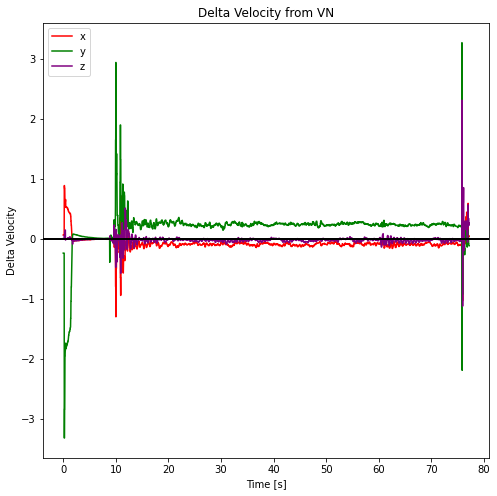

In [4]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time, dvx, color='red', label='x')
ax.plot(time, dvy, color='green', label='y')
ax.plot(time, dvz, color='purple', label='z')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Delta Velocity from VN")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Delta Velocity")
ax.legend()
plt.show()

In [5]:
q1 = df['Qtn[0]']
q2 = df['Qtn[1]']
q3 = df['Qtn[2]']
q4 = df['Qtn[3]']

quats = np.stack((q1, q2, q3, q4))

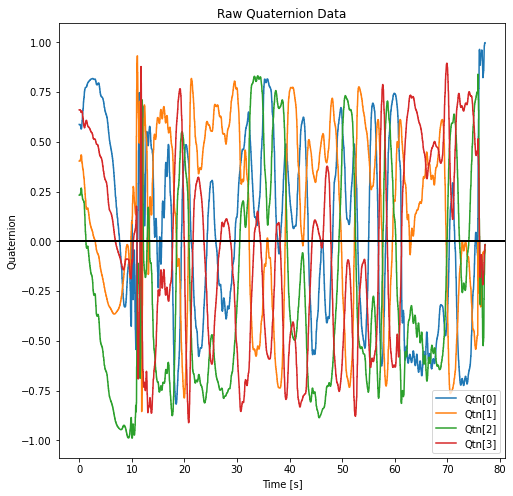

In [6]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time, quats[0], label='Qtn[0]')
ax.plot(time, quats[1], label='Qtn[1]')
ax.plot(time, quats[2], label='Qtn[2]')
ax.plot(time, quats[3], label='Qtn[3]')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Raw Quaternion Data")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Quaternion")
ax.legend()
plt.show()

In [7]:
def quant2ypr(quant):
    """
    Extracting Euler angles (yaw, pitch, & roll) from the 
    Direction Cosine Matrix (DCM)
    """
    
    q1 = quant[0]
    q2 = quant[1]
    q3 = quant[2]
    q4 = quant[3]
    
    c11 = q4**2 + q1**2 - q2**2 - q3**2
    c12 = 2 * ((q1 * q2) + (q3 * q4))
    c13 = 2 * ((q1 * q3) - (q2 * q4))
    c21 = 2 * ((q1 * q2) - (q3 * q4))
    c22 = q4**2 - q1**2 + q2**2 - q3**2
    c23 = 2 * ((q2 * q3) + (q1 * q4))
    c31 = 2 * ((q1 * q3) + (q2 * q4))
    c32 = 2 * ((q2 * q3) - (q1 * q4))
    c33 = q4**2 - q1**2 - q2**2 + q3**2
    
    C = [[c11, c12, c13],
         [c21, c22, c23],
         [c31, c32, c33]]
    
    yaw = atan2(c12, c11) * 180/pi
    pitch = -asin(c13) * 180/pi
    roll = atan2(c23, c33) * 180/pi
    
    return np.array([yaw, pitch, roll])

In [8]:
def euler_from_quat(quat):
    """
    Convert a quaternion into euler angles
    roll is rotation around x, pitch around
    y and yaw around z. Angles returned in degrees
    """
    qx = quat[0]
    qy = quat[1]
    qz = quat[2]
    qw = quat[3]
    
    # roll (x-axis rotation)
    t0 = 2 * (qw * qx + qy * qz)
    t1 = 1 - 2 * (qx**2 + qy**2)
    roll = atan2(t0, t1)
    
    # pitch (y-axis rotation)
    t2 = 2 * (qw * qy - qz * qx)
    # handle singularity
    t2 = 1.0 if t2 > 1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch = asin(t2)
    
    # yaw (z-axis rotation)
    t3 = 2 * (qw * qz + qx * qy)
    t4 = 1 - 2 * (qy**2 + qz**2)
    yaw = atan2(t3, t4)
    
    return np.array([yaw, pitch, roll]) * 180/pi

In [9]:
yaw_q, pitch_q, roll_q = np.zeros(size), np.zeros(size), np.zeros(size)

for i in range(size):
    quat = quats[:, i]
#     print(quat)
#     ypr = quant2ypr(quat)
    ypr = euler_from_quat(quat)
    yaw_q[i], pitch_q[i], roll_q[i] = ypr[0], ypr[1], ypr[2]
    
# yaw_q.shape

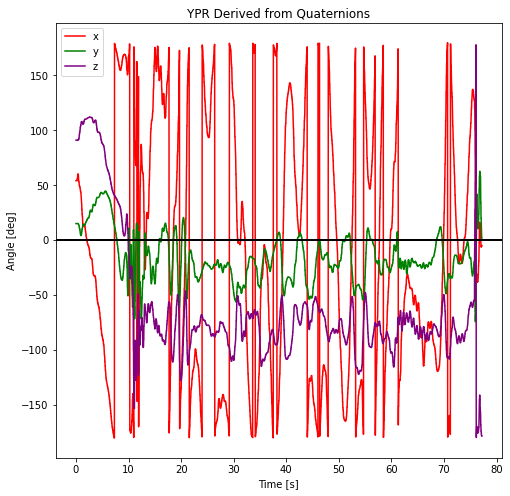

In [10]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time, yaw_q, color='red', label='x')
ax.plot(time, pitch_q, color='green', label='y')
ax.plot(time, roll_q, color='purple', label='z')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("YPR Derived from Quaternions")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

## Using Raw YPR from VN

In [11]:
# Just using the raw values directly from the VN
yaw = df['Yaw'].values
pitch = df['Pitch'].values
roll = df['Roll'].values

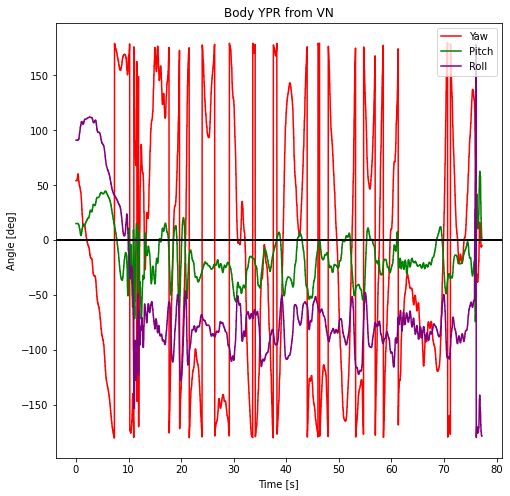

In [12]:
fig = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time, yaw, color='red', label='Yaw')
ax.plot(time, pitch, color='green', label='Pitch')
ax.plot(time, roll, color='purple', label='Roll')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Body YPR from VN")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

## Comparing raw vs derived

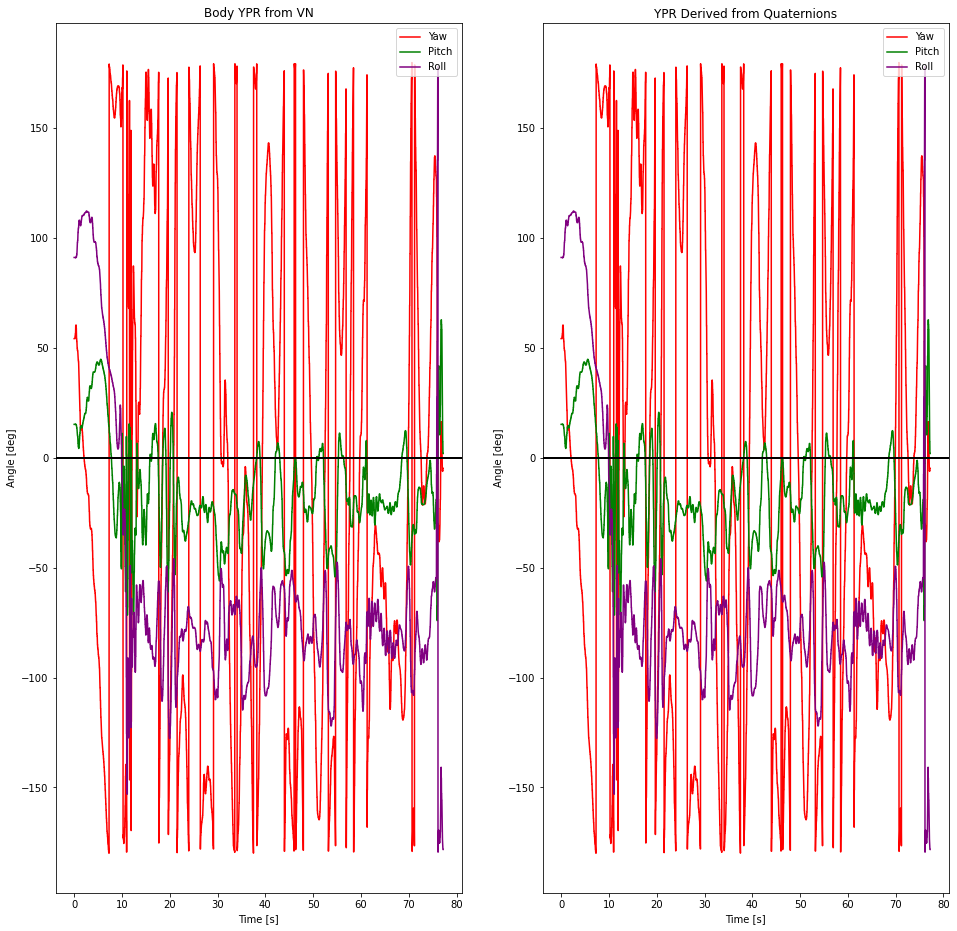

In [17]:
fig = plt.figure(1, figsize=(16,16))
ax1 = plt.subplot(121)
ax1.plot(time, yaw, color='red', label='Yaw')
ax1.plot(time, pitch, color='green', label='Pitch')
ax1.plot(time, roll, color='purple', label='Roll')
plt.axhline(y=0, color='black', linewidth=2)
ax1.set_title("Body YPR from VN")
ax1.set_xlabel('Time [s]')
ax1.set_ylabel("Angle [deg]")
ax1.legend()
# plt.show()

ax2 = plt.subplot(122)
ax2.plot(time, yaw_q, color='red', label='Yaw')
ax2.plot(time, pitch_q, color='green', label='Pitch')
ax2.plot(time, roll_q, color='purple', label='Roll')
plt.axhline(y=0, color='black', linewidth=2)
ax2.set_title("YPR Derived from Quaternions")
ax2.set_xlabel('Time [s]')
ax2.set_ylabel("Angle [deg]")
ax2.legend()
plt.show()

The derived data appears to match the raw yaw, pitch, and roll data recorded by the VN.

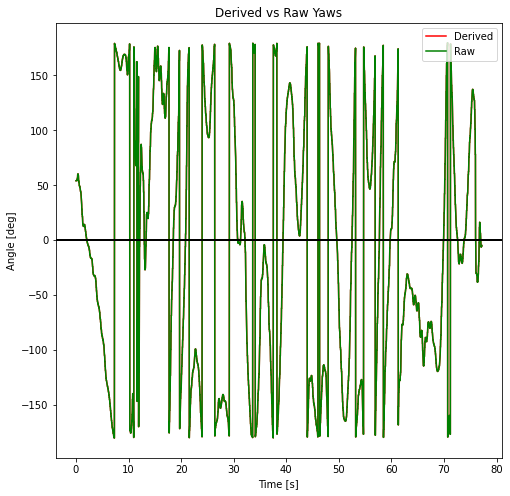

In [14]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time, yaw_q, color='red', label='Derived')
ax.plot(time, yaw, color='green', label='Raw')
# ax.plot(time, roll_q, color='purple', label='z')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Derived vs Raw Yaws")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

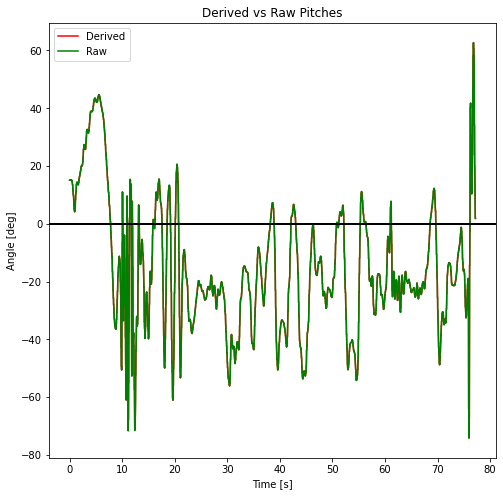

In [15]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time, pitch_q, color='red', label='Derived')
ax.plot(time, pitch, color='green', label='Raw')
# ax.plot(time, roll_q, color='purple', label='z')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Derived vs Raw Pitches")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

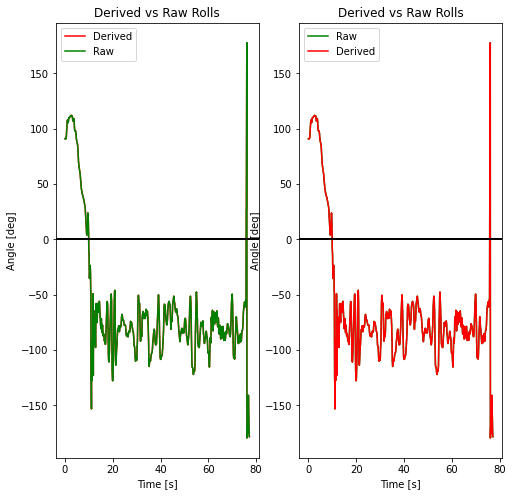

In [16]:
fig1 = plt.figure(1, figsize=(8,8))
ax1 = plt.subplot(121)
ax1.plot(time, roll_q, color='red', label='Derived')
ax1.plot(time, roll, color='green', label='Raw')
plt.axhline(y=0, color='black', linewidth=2)
ax1.set_title("Derived vs Raw Rolls")
ax1.set_xlabel('Time [s]')
ax1.set_ylabel("Angle [deg]")
ax1.legend()

# Plot in reversed order to verify data is overlapping
ax2 = plt.subplot(122)
ax2.plot(time, roll, color='green', label='Raw')
ax2.plot(time, roll_q, color='red', label='Derived')
plt.axhline(y=0, color='black', linewidth=2)
ax2.set_title("Derived vs Raw Rolls")
ax2.set_xlabel('Time [s]')
ax2.set_ylabel("Angle [deg]")
ax2.legend()
plt.show()

Checks out